# Imports

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

# Read Data

In [32]:
# read data
dataFileName = ('../_data/_processed/' + 'processed_for_viz_eric.csv')
df = pd.read_csv(dataFileName)
print(df.columns)

Index(['name', 'rating', 'genre', 'score', 'votes', 'director', 'writer',
       'star', 'country', 'budget', 'gross revenue', 'company', 'runtime',
       'gross profit', 'release month', 'release day', 'release year',
       'release month num', 'release date', 'release quarter',
       'release day of week'],
      dtype='object')


# Train a Linear Regression Model

In [33]:
# fitting a regression model
predictors = [
    'rating', 'genre', 'budget', 'runtime', 'release quarter'] #'director', 'writter', 'star', 'company' are other options but they lead to 
outcome = 'score'
testSize = 0.4

# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=testSize, random_state=1)

lm = LinearRegression()
lm.fit(train_X, train_y)

# print coefficients
print('Table 6.3')
print('intercept ', lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures (training data)
regressionSummary(train_y, lm.predict(train_X))

Table 6.3
intercept  0.6112170204034726
           Predictor   coefficient
0             budget -8.899069e-10
1            runtime  2.242172e-02
2    release quarter  3.361121e-03
3           rating_G  3.293769e+00
4       rating_NC-17  3.723845e+00
5   rating_Not Rated  3.538829e+00
6          rating_PG  3.001302e+00
7       rating_PG-13  3.102022e+00
8           rating_R  3.251481e+00
9       rating_TV-MA  2.625422e+00
10    rating_Unrated  3.361830e+00
11          rating_X  6.855627e-14
12   genre_Adventure  2.059858e-01
13   genre_Animation  9.818527e-01
14   genre_Biography  6.227433e-01
15      genre_Comedy  1.702764e-01
16       genre_Crime  3.356224e-01
17       genre_Drama  3.459601e-01
18      genre_Family -4.318690e-02
19     genre_Fantasy -9.035252e-02
20      genre_Horror -1.975791e-01
21     genre_Mystery  2.072160e-01
22     genre_Romance  6.923182e-01
23      genre_Sci-Fi  7.484086e-02
24    genre_Thriller -2.193206e-01
25     genre_Western -3.668944e-02

Regression sta

# Make Predictions on Validation Data

In [34]:
# Use predict() to make predictions on a new set

lm_pred = lm.predict(valid_X)
result = pd.DataFrame({'Predicted': lm_pred, 'Actual': valid_y, 'Residual': valid_y - lm_pred})

print('Table 6.4')
print(result.head(20))


Table 6.4
      Predicted  Actual  Residual
3973   5.933084     6.1  0.166916
2800   6.570837     6.9  0.329163
2406   7.504747     7.9  0.395253
1379   6.278659     7.1  0.821341
2083   8.396076     8.6  0.203924
4091   5.776705     7.5  1.723295
2374   6.687602     6.8  0.112398
2678   5.851636     3.1 -2.751636
4477   7.177089     7.5  0.322911
1264   6.804905     6.0 -0.804905
1922   6.073645     5.6 -0.473645
4300   6.833452     6.1 -0.733452
3147   6.116566     5.6 -0.516566
1959   6.771960     7.1  0.328040
169    5.884507     6.0  0.115493
3853   6.444081     5.1 -1.344081
5268   6.192159     5.8 -0.392159
285    6.762647     7.0  0.237353
2896   6.143954     5.6 -0.543954
2024   6.515159     6.0 -0.515159


# Evaluate the Performance

In [35]:
# print performance measures
regressionSummary(valid_y, lm_pred)


Regression statistics

                      Mean Error (ME) : -0.0026
       Root Mean Squared Error (RMSE) : 0.8543
            Mean Absolute Error (MAE) : 0.6490
          Mean Percentage Error (MPE) : -2.3440
Mean Absolute Percentage Error (MAPE) : 11.2349


Figure 6.1
1.0


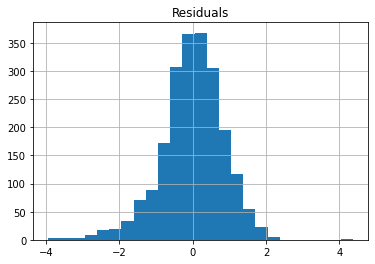

In [36]:
# plotting histogram of validation errors
bins = 25
residual_bound = 1406

lm_pred = lm.predict(valid_X)
all_residuals = valid_y - lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75%
print('Figure 6.1')
print(len(all_residuals[(all_residuals > -residual_bound) & (all_residuals < residual_bound)]) / len(all_residuals))

pd.DataFrame({'Residuals': all_residuals}).hist(bins=bins)
plt.show()

# Variable Selection

In [37]:
# backward elimination (stepwise)

def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

allVariables = train_X.columns
best_model_be, best_variables_be = backward_elimination(allVariables, train_model, score_model, verbose=True)

print('Table 6.6')
print(best_variables_be)

regressionSummary(valid_y, best_model_be.predict(valid_X[best_variables_be]))

Variables: budget, runtime, release quarter, rating_G, rating_NC-17, rating_Not Rated, rating_PG, rating_PG-13, rating_R, rating_TV-MA, rating_Unrated, rating_X, genre_Adventure, genre_Animation, genre_Biography, genre_Comedy, genre_Crime, genre_Drama, genre_Family, genre_Fantasy, genre_Horror, genre_Mystery, genre_Romance, genre_Sci-Fi, genre_Thriller, genre_Western
Start: score=7974.43
Step: score=7972.43, remove rating_X
Step: score=7970.44, remove genre_Western
Step: score=7968.44, remove genre_Family
Step: score=7966.48, remove genre_Sci-Fi
Step: score=7964.54, remove release quarter
Step: score=7962.82, remove genre_Fantasy
Step: score=7961.10, remove genre_Thriller
Step: score=7959.68, remove genre_Mystery
Step: score=7959.68, remove None
Table 6.6
['budget', 'runtime', 'rating_G', 'rating_NC-17', 'rating_Not Rated', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_TV-MA', 'rating_Unrated', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime', '

In [38]:
# forward selection
print('Table 6.7')

# the initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model_fs, best_variables_fs = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables_fs)

regressionSummary(valid_y, best_model_fs.predict(valid_X[best_variables_fs]))

Table 6.7
Variables: budget, runtime, release quarter, rating_G, rating_NC-17, rating_Not Rated, rating_PG, rating_PG-13, rating_R, rating_TV-MA, rating_Unrated, rating_X, genre_Adventure, genre_Animation, genre_Biography, genre_Comedy, genre_Crime, genre_Drama, genre_Family, genre_Fantasy, genre_Horror, genre_Mystery, genre_Romance, genre_Sci-Fi, genre_Thriller, genre_Western
Start: score=8875.84, constant
Step: score=8278.00, add runtime
Step: score=8167.20, add genre_Animation
Step: score=8115.73, add genre_Biography
Step: score=8072.74, add genre_Drama
Step: score=8036.96, add genre_Crime
Step: score=8014.13, add rating_R
Step: score=7992.00, add genre_Comedy
Step: score=7986.36, add genre_Adventure
Step: score=7981.45, add rating_PG
Step: score=7974.75, add rating_PG-13
Step: score=7971.69, add genre_Horror
Step: score=7969.92, add budget
Step: score=7969.84, add genre_Romance
Step: score=7969.84, add None
['runtime', 'genre_Animation', 'genre_Biography', 'genre_Drama', 'genre_Cri

In [39]:
# stepwise regression
print('Table 6.8')

best_model_stepwise, best_variables_stepwise = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables_stepwise)
regressionSummary(valid_y, best_model_stepwise.predict(valid_X[best_variables_stepwise]))

Table 6.8
Variables: budget, runtime, release quarter, rating_G, rating_NC-17, rating_Not Rated, rating_PG, rating_PG-13, rating_R, rating_TV-MA, rating_Unrated, rating_X, genre_Adventure, genre_Animation, genre_Biography, genre_Comedy, genre_Crime, genre_Drama, genre_Family, genre_Fantasy, genre_Horror, genre_Mystery, genre_Romance, genre_Sci-Fi, genre_Thriller, genre_Western
Start: score=8875.84, constant
Step: score=8278.00, add runtime
Step: score=8167.20, add genre_Animation
Step: score=8115.73, add genre_Biography
Step: score=8072.74, add genre_Drama
Step: score=8036.96, add genre_Crime
Step: score=8014.13, add rating_R
Step: score=7992.00, add genre_Comedy
Step: score=7986.36, add genre_Adventure
Step: score=7981.45, add rating_PG
Step: score=7974.75, add rating_PG-13
Step: score=7971.69, add genre_Horror
Step: score=7969.92, add budget
Step: score=7969.29, remove rating_R
Step: score=7968.73, add rating_NC-17
Step: score=7968.23, add rating_Not Rated
Step: score=7968.11, add ge

# Use the prediction models

In [47]:
# create a movie (in this data a movie can't have more than one rating nor more than one genre)
newMovie = pd.DataFrame([{
    'budget': 8_000_000,
    'runtime': 3*60,
    'release quarter': 4, # 1-4
    'rating_G': 0,
    'rating_NC-17': 0,
    'rating_Not Rated': 0,
    'rating_PG': 0,
    'rating_PG-13': 0,
    'rating_R': 1,
    'rating_TV-MA': 0,
    'rating_Unrated': 0,
    'rating_X': 0,
    'genre_Adventure': 0,
    'genre_Animation': 0,
    'genre_Biography': 0,
    'genre_Comedy': 0,
    'genre_Crime': 1,
    'genre_Drama': 0,
    'genre_Family': 0,
    'genre_Fantasy': 0,
    'genre_Horror': 0,
    'genre_Mystery': 0,
    'genre_Romance': 0,
    'genre_Sci-Fi': 0,
    'genre_Thriller': 0,
    'genre_Western': 0
}])

newMovie_thin = newMovie.loc[:, ~(newMovie == 0).any()]

# predict it's score
print(f'What score do we expect from a new movie with the following features?\n{newMovie_thin.T}\n')
print(f'{outcome} per original model (all predictors): {lm.predict(newMovie[X.columns])}')
print(f'{outcome} per backward elimination: {best_model_be.predict(newMovie[best_variables_be])}')
print(f'{outcome} per forward selection: {best_model_fs.predict(newMovie[best_variables_fs])}')
print(f'{outcome} per stepwise: {best_model_stepwise.predict(newMovie[best_variables_stepwise])}')

What score do we expect from a new movie with the following features?
                       0
budget           8000000
runtime              180
release quarter        4
rating_R               1
genre_Crime            1

score per original model (all predictors): [8.24055586]
score per backward elimination: [8.24032312]
score per forward selection: [8.24649853]
score per stepwise: [8.23459876]
